## 1. **Import Project Related Packages**

*   numpy == 1.21.6
*   matplotlib == 3.2.2
*   torch == 1.12.1+cu113
*   torchvision == 0.13.1+cu113


In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import ssl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torchsummary import summary
from torchvision import transforms
from torchvision import datasets
ssl._create_default_https_context = ssl._create_unverified_context


## 2. **Check Runtime's GPU Availability**


In [3]:
train_on_gpu = torch.cuda.is_available()
# check whether CUDA is available
if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    

CUDA is available


## 3. **Set Up Hyper Parameter Space:**


1.   Train/Validation data's training process
2.   After fine tuning, train model and generate test data accuracy



In [4]:
# Batch size for each data iteration
# Make a change from 128 to 32
BATCH_SIZE = 128

# The ratio of split the validation set out of the original training set
VALID_RATIO = 0.1

# ResNet's number of input channel
CHANNEL = 64

# Number of epoch
# Change from 600 to 10
EPOCH_NUM = 50

# Learning Rate
LR = 0.01
# Learning Rate Decay Period. For example, apply decay to learning rate every X epochs
LR_DECAY_PERIOD = 3

#Lerning Rate Decay. 
# For example, if the current lr is 0.1, the lr after decay is 0.5
LR_DECAY = 0.7

# Weight Decay
WEIGHT_DECAY = 0.001

# Momentum
MOMENTUM = 0.9

# # Dampening
# dampening = 0.1


## 4. **Extract and Optimize the RAW CIFAR-10 Data:**

1.   Create directories for Model and Log data
2.   Customize the Transform process for train and test data
3.   Split 10% of the RAW train data as valid data
4.   Generate the:
    *   Train and Valid Data Iteration: 50,000 rows of data
    *   Train Data Iteration:           45,000 rows of data
    *   Valid Data Iteration:            5,000 rows of data
    *   Test Data Iteration:            10,000 rows of data


In [5]:
# Create directories for Model and Log data
!mkdir -p ./Train_With_Test_Log ./Train_With_Test_Model ./Train_With_Valid_Log ./Train_With_Valid_Model


In [6]:
# Customize the Transform process for train and test data
def train_transform(x):
    image_aug = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    # transforms.ColorJitter(brightness=0.7,contrast=0.7,hue=0.5),
                                    # transforms.RandomRotation(degrees=(0, 20)),
                                    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                                    # transforms.RandomErasing(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914,0.4822,0.4465), 
                                                         (0.2023,0.1994,0.2010))])
    x = image_aug(x)
    return x

# Customize the Transform process for train and test data
def test_transform(x):
    image_aug = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914,0.4822,0.4465), 
                                                                                (0.2023,0.1994,0.2010))])
    x = image_aug(x)
    return x


In [7]:
# Download the RAW data                                
train_valid_ds = datasets.CIFAR10('Data', 
                                  train=True, 
                                  download=True, 
                                  transform=train_transform)
test_ds = datasets.CIFAR10('Data', 
                           train=False, 
                           download=True, 
                           transform=test_transform)


100%|██████████| 170498071/170498071 [00:05<00:00, 29893031.58it/s]


Extracting Data/cifar-10-python.tar.gz to Data
Files already downloaded and verified


In [8]:
# Split 10% of the RAW train data as valid data
valid_ds_size = int(len(train_valid_ds) * VALID_RATIO)
train_ds_size = len(train_valid_ds) - valid_ds_size

# Split Train and Valid data
train_ds, valid_ds = torch.utils.data.random_split(train_valid_ds, 
                                                   [train_ds_size, valid_ds_size]) 


## 5. **Acquiring the Re-orgnaized Datasets to Data Iteration format:**

*   train_valid_iter
*   train_iter
*   valid_iter
*   test_iter    


In [9]:
# Generate the:
# 1) Train and Valid Data Loader: 50,000 rows of data
# 2) Train Data Loader: 45,000 rows of data
# 3) Valid Data Loader: 5,000 rows of data
# 4) Test Data Loader: 10,000 rows of data

# Train and Valid Data Loader: 50,000 rows of data
train_valid_loader = torch.utils.data.DataLoader(train_valid_ds, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=True, 
                                                 num_workers=3)

# Train Valid Data Loader (Removed the 5,000 row for Validation): 50,000 rows of data
train_loader = torch.utils.data.DataLoader(train_ds, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=3)

# Valid Data Loader: 5,000 rows of data
valid_loader = torch.utils.data.DataLoader(valid_ds, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False, 
                                           num_workers=3)

# Test Data Loader: 10,000 rows of data
test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False, 
                                          num_workers=3)


# 6. Define the ResNet Model Architecture


1.   Basic Block
2.   General ResNet Architecture


In [10]:
# Basic Block for ResNet Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [12]:
# ResNet Module
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = CHANNEL

        self.conv1 = nn.Conv2d(3, CHANNEL, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(CHANNEL)
        self.layer1 = self._make_layer(block, CHANNEL, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*CHANNEL, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*CHANNEL, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 8*CHANNEL, num_blocks[3], stride=2)
        self.linear = nn.Linear(4*CHANNEL*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project_customized_model():
    block = [3,5,3,0] # 
    return ResNet(BasicBlock, block)
    

# **7. Training and Validating the Model --- Fine Tunning Hyper Parameters**


*   Tuning the Hyper Parameters with Training/Validation Data


In [13]:
def train_with_valid(net,
                     train_loader,
                     valid_loader,
                     batch_size,
                     channel,
                     epoch_num,
                     lr,
                     weight_decay,
                     lr_decay_period,
                     high_speed_lr_decay,
                     low_speed_lr_decay,
                     momentum):

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    start_time = datetime.datetime.now()
    model_path = 'Train_With_Valid_Model/' + str(start_time) + '_model.pt'
    best_test_acc = 0
    print('Start trainning, time: ', start_time)
    f = open("Train_With_Valid_Log/" + str(start_time) + ".txt", 'a')
    f.write('This is the method from paper, without grey random\n')
    f.write('hyperparamter:\n')
    f.write('lr_decay_period:' + str(lr_decay_period) + '\n')
    f.write('batch_size:' + str(batch_size) + '\n')
    f.write('lr:' + str(lr) + '\n')
    f.write('epoch_num:' + str(epoch_num) + '\n')
    f.write('momentum:' + str(momentum) + '\n')
    f.write('weight_decay:' + str(weight_decay) + '\n')
    f.write('channel:' + str(channel) + '\n')
    f.write('Begin training, time: ' + str(start_time) + '\n')
    print("Total #Params: ", sum(p.numel() for p in net.parameters() if p.requires_grad))
    print("-----------------------------------------------------------------------------------------------------")
    line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
        "Epoch", "Train loss", "Valid loss", "Train acc", "Valid acc", "lr", "Running time")
    print(line_new)
    print("=====================================================================================================")
    for epoch in range(epoch_num):
        if epoch != 0 and epoch % lr_decay_period == 0:
            print('***lr before decay: ', lr)
            if lr > 0.002:
                lr_decay = high_speed_lr_decay
            else:
                lr_decay = low_speed_lr_decay
            lr *= lr_decay
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            print('***lr_decay: ', lr_decay)
            print('***lr after decay: ', lr)
            f.write('lr decays \n')
        train_loss = 0.0
        train_acc = 0.0
        net.train()
        epoch_start_time = datetime.datetime.now()
        for i, train_data in enumerate(train_loader):
            inputs, labels = train_data
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            # forward + backward
            predicted_output = net(inputs)
            fit = loss(predicted_output, labels)
            fit.backward()
            # fit.sum().backward()
            optimizer.step()
            train_loss += fit.item()
            _, pred = predicted_output.max(1)
            num_correct = (pred == labels).sum().item()
            acc = num_correct / inputs.shape[0]
            train_acc += acc
        train_loss = train_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = train_acc / len(train_loader)
        train_acc_history.append(train_acc)
        test_loss = 0.0
        test_acc = 0.0

        net.eval()
        for j, data in enumerate(valid_loader):
            with torch.no_grad():
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                predicted_output = net(images)
                fit = loss(predicted_output, labels)
                test_loss += fit.item()
                _, pred = predicted_output.max(1)
                num_correct = (pred == labels).sum().item()
                acc = num_correct / images.shape[0]
                test_acc += acc
        test_loss = test_loss / len(valid_loader)
        test_loss_history.append(test_loss)
        test_acc = test_acc / len(valid_loader)
        test_acc_history.append(test_acc)
        epoch_end_time = datetime.datetime.now()

        line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
            epoch,
            round(train_loss, 5),
            round(test_loss, 5),
            round(train_acc, 5),
            round(test_acc, 5),
            round(lr, 8),
            str(epoch_end_time - epoch_start_time))
        print(line_new)

        # print('Epoch %s, Train loss %.6f, Valid loss %.6f, Train acc %.6f, Valid acc %.6f, Running time %s' % (
        # epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time))
        f.write('Epoch %s, Train loss %.6f, Valid loss %.6f, Train acc %.6f, Valid acc %.6f, Running time %s' % (
        epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time) + '\n')
        # save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(net.state_dict(), model_path)

    print('Finished trainning, end time:', epoch_end_time, 'Total running time,', epoch_end_time - start_time)
    f.write('Finished trainning, end time:' + str(epoch_end_time) + 'Total running time,' + str(
        epoch_end_time - start_time) + '\n')

    # count the number of trainable parametes
    print(sum(p.numel() for p in net.parameters() if p.requires_grad))
    f.write('The number of trainable parametes:' + str(sum(p.numel() for p in net.parameters() if p.requires_grad)) + '\n')

    plt.figure()
    plt.plot(range(epoch_num), train_loss_history, '-', linewidth=3, label='Train error')
    plt.plot(range(epoch_num), test_loss_history, '-', linewidth=3, label='Valid error')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Valid_Log/' + str(start_time) + '_loss_history.png')

    plt.figure()
    plt.plot(range(epoch_num), train_acc_history, '-', linewidth=3, label='Train accuracy')
    plt.plot(range(epoch_num), test_acc_history, '-', linewidth=3, label='Valid accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Valid_Log/' + str(start_time) + '_acc_history.png')


# 8 **Train the ResNet model and Classifying the Test Data**


*   Based on the Fine Tuning Hyper Parameters to train the overall traning+valid dataset
*   Check the Test Accuracy


In [14]:
# from numpy.ma.core import exp
def train_with_test(net,
                    train_valid_loader,
                    test_loader,
                    batch_size,
                    channel,
                    epoch_num,
                    lr,
                    lr_decay,
                    weight_decay,
                    lr_decay_period,
                    momentum):

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    start_time = datetime.datetime.now()
    model_path = 'Train_With_Test_Model/' + str(start_time) + '_model.pt'
    best_test_acc = 0
    print('Start trainning, time: ', start_time)
    f = open("Train_With_Test_Log/" + str(start_time) + ".txt", 'a')
    f.write('Here is the training/test section data\n')
    f.write('hyperparamter:\n')
    f.write('lr_decay_period:' + str(lr_decay_period) + '\n')
    f.write('batch_size:' + str(batch_size) + '\n')
    f.write('lr:' + str(lr) + '\n')
    f.write('epoch_num:' + str(epoch_num) + '\n')
    f.write('momentum:' + str(momentum) + '\n')
    f.write('weight_decay:' + str(weight_decay) + '\n')
    f.write('channel:' + str(channel) + '\n')
    f.write('Begin training, time: ' + str(start_time) + '\n')
    print("Total #Params: ", sum(p.numel() for p in net.parameters() if p.requires_grad))
    print("-----------------------------------------------------------------------------------------------------")
    line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
        "Epoch", "Train loss", "Test loss", "Train accuracy", "Test accuracy", "lr", "Running time")
    print(line_new)
    print("-----------------------------------------------------------------------------------------------------")
    for epoch in range(epoch_num):

        #Learning Rate Decay
        if epoch != 0 and epoch % lr_decay_period == 0:
          print('---Learning Rate before decay: ', lr)
          lr_decay = LR_DECAY
          if(lr>0.001):
            lr*=lr_decay
          optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
          print('---lr_decay: ', LR_DECAY)
          print('---lr after decay: ', lr)
          f.write('lr decays \n')

        train_loss = 0.0
        train_acc = 0.0
        net.train()
        epoch_start_time = datetime.datetime.now()
        for i, train_data in enumerate(train_valid_loader):
            inputs, labels = train_data
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            # forward + backward
            predicted_output = net(inputs)
            fit = loss(predicted_output, labels)
            fit.backward()
            # fit.sum().backward()
            optimizer.step()
            train_loss += fit.item()
            _, pred = predicted_output.max(1)
            num_correct = (pred == labels).sum().item()
            acc = num_correct / inputs.shape[0]
            train_acc += acc
        train_loss = train_loss / len(train_valid_loader)
        train_loss_history.append(train_loss)
        train_acc = train_acc / len(train_valid_loader)
        train_acc_history.append(train_acc)
        test_loss = 0.0
        test_acc = 0.0

        net.eval()
        for j, data in enumerate(test_loader):
            with torch.no_grad():
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                predicted_output = net(images)
                fit = loss(predicted_output, labels)
                test_loss += fit.item()
                _, pred = predicted_output.max(1)
                num_correct = (pred == labels).sum().item()
                acc = num_correct / images.shape[0]
                test_acc += acc
        test_loss = test_loss / len(test_loader)
        test_loss_history.append(test_loss)
        test_acc = test_acc / len(test_loader)
        test_acc_history.append(test_acc)
        epoch_end_time = datetime.datetime.now()

        line_new = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
            epoch,
            round(train_loss, 5),
            round(test_loss, 5),
            round(train_acc, 5),
            round(test_acc, 5),
            round(lr, 8),
            str(epoch_end_time - epoch_start_time))
        print(line_new)

        # print('Epoch %s, Train loss %.6f, Test loss %.6f, Train acc %.6f, Test acc %.6f, Running time %s' % (
        # epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time))
        f.write('Epoch %s, Train loss %.6f, Test loss %.6f, Train acc %.6f, Test acc %.6f, Running time %s' % (
        epoch, train_loss, test_loss, train_acc, test_acc, epoch_end_time - epoch_start_time) + '\n')
        # save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(net.state_dict(), model_path)

    print('Finished trainning, end time:', epoch_end_time, 'Total running time,', epoch_end_time - start_time)
    f.write('Finished trainning, end time:' + str(epoch_end_time) + 'Total running time,' + str(
        epoch_end_time - start_time) + '\n')

    # count the number of trainable parametes
    print(sum(p.numel() for p in net.parameters() if p.requires_grad))
    f.write('The number of trainable parameters:' + str(sum(p.numel() for p in net.parameters() if p.requires_grad)) + '\n')

    plt.figure()
    plt.plot(range(epoch_num), train_loss_history, '-', linewidth=3, label='Train error')
    plt.plot(range(epoch_num), test_loss_history, '-', linewidth=3, label='Test error')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Test_Log/' + str(start_time) + '_loss_history.png')

    plt.figure()
    plt.plot(range(epoch_num), train_acc_history, '-', linewidth=3, label='Train accuracy')
    plt.plot(range(epoch_num), test_acc_history, '-', linewidth=3, label='Test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_With_Test_Log/' + str(start_time) + '_acc_history.png')

# 9 **Execution**


*   Training and Validating the Model --- Fine Tunning Hyper Parameters
*   Train the ResNet model and Classifying the Test Data


## 9.1 Execution for Training and Validating the Model --- Fine Tunning HyperParams

In [15]:
# # Training and Validating the Model
# net_for_train_with_valid = project_customized_model().cuda()
# summary(net_for_train_with_valid, (3, 32, 32))
# train_with_valid(net_for_train_with_valid,
#                  train_loader,
#                  valid_loader,
#                  BATCH_SIZE,
#                  CHANNEL,
#                  EPOCH_NUM, 
#                  LR, 
#                  WEIGHT_DECAY, 
#                  LR_DECAY_PERIOD,
#                  HIGH_SPEED_LR_DECAY,
#                  LOW_SPEED_LR_DECAY,
#                  MOMENTUM)
# # 

## 9.2 Execution for Train the ResNet model and Generate the Test Data Accuracy

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

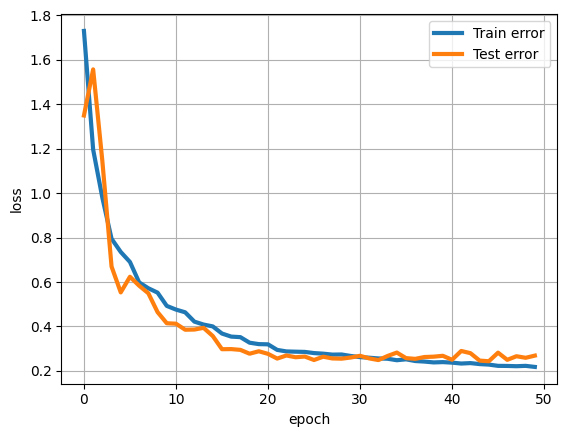

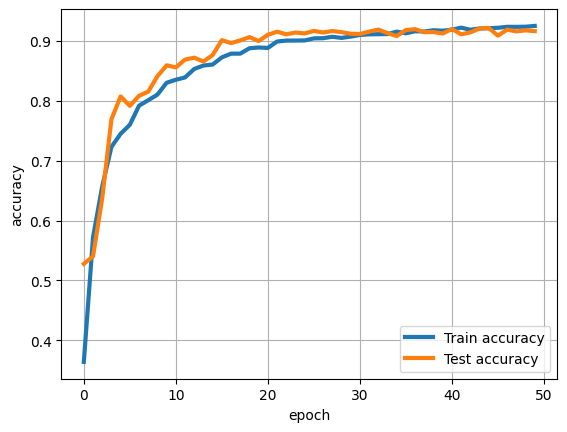

In [16]:
# Train the ResNet model and Classifying the Test Data
net_for_train_with_test = project_customized_model().cuda()
summary(net_for_train_with_test, (3, 32, 32))
train_with_test(net_for_train_with_test,
                train_valid_loader, 
                test_loader, 
                BATCH_SIZE,
                CHANNEL,
                EPOCH_NUM, 
                LR, 
                LR_DECAY,
                WEIGHT_DECAY, 
                LR_DECAY_PERIOD,
                MOMENTUM)


# 10 **Find the Best Performance Model through Test Accuracy**


*   Get the top test accuracy model through model .pt file
*   Produce the Test Accuracy result based on this model

-------------------------------------------------
Best Model Saved       Test loss        Test acc
-------------------------------------------------
     Best model         0.24355         0.92158
-------------------------------------------------


torch.return_types.max(
values=tensor([11.7779,  6.2649, 10.5225,  9.9733, 16.3553,  8.0600,  8.7919,  9.4143,
        12.3593, 11.0964, 11.4439,  6.7724,  8.3501, 13.8943, 15.2474, 12.6817],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([7, 5, 8, 0, 8, 4, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0'))
tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')
tensor(0.2775, device='cuda:0', grad_fn=<NllLossBackward0>)


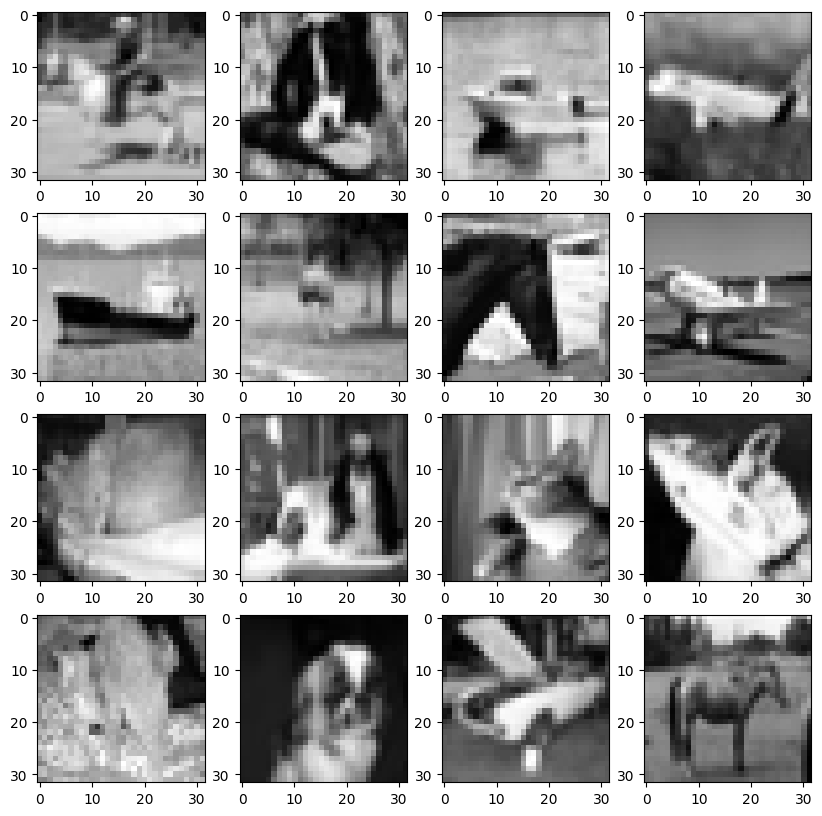

In [17]:
# #test the best test model acc
# start_time = "2023-04-07 21:11:59.803520"
# f = open("Train_With_Test_Log/"+str(start_time)+".txt",'a')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = project_customized_model().to(device)
# model_path = 'Train_With_Test_Model/' + str(start_time) + '_model.pt'
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
# loss = nn.CrossEntropyLoss()
# test_loss = 0.0
# test_acc = 0.0
# model.eval()
# for j, data in enumerate(test_loader):
#     with torch.no_grad():
#         images, labels = data
#         images = images.cuda()
#         labels = labels.cuda()
#         predicted_output = model(images)
#         fit = loss(predicted_output,labels)
#         test_loss += fit.item()
#         _, pred = predicted_output.max(1)
#         num_correct = (pred==labels).sum().item()
#         acc = num_correct / images.shape[0]
#         test_acc += acc
# test_loss = test_loss / len(test_loader)
# test_acc = test_acc / len(test_loader)
# epoch_end_time = datetime.datetime.now()
# # print('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc))
# print("-------------------------------------------------")
# line_new = "{:>15} {:>15} {:>15}".format(
#         "Best Model Saved", "Test loss", "Test acc")
# print(line_new)
# print("=================================================")
# line_new = "{:>15} {:>15} {:>15}".format(
#     "Best model",
#     round(test_loss, 5),
#     round(test_acc, 5))
# print(line_new)
# print("-------------------------------------------------")
# print("\n")
# f.write('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc)+'\n')

# # test the output of the model
# predicted_output = model(images)
# print(torch.max(predicted_output, 1))
# f.write(str(torch.max(predicted_output, 1))+'\n')
# fit = loss(predicted_output, labels)
# print(labels)
# f.write(str(labels)+'\n')
# print(fit)
# f.write(str(fit)+'\n')
# f.close()

# plt.figure(figsize=(10,10))
# for idx in np.arange(0,16):
#     plt.subplot(4,4,idx+1)
#     plt.imshow(images[idx].cpu()[0,:,:].squeeze(), cmap=plt.cm.gray)
# plt.savefig('Train_With_Test_Log/'+str(start_time)+'_test_instances.png')
import glob
import os
list_of_files = glob.glob('/content/Train_With_Test_Model/*')
latest_file = max(list_of_files, key=os.path.getctime)
start_time = latest_file.split('/')[-1].split('_model.pt')[0]
f = open("Train_With_Test_Log/"+start_time+".txt",'a')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = project_customized_model().to(device)
model_path = 'Train_With_Test_Model/' + start_time + '_model.pt'
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
loss = nn.CrossEntropyLoss()
test_loss = 0.0
test_acc = 0.0
model.eval()
for j, data in enumerate(test_loader):
    with torch.no_grad():
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        predicted_output = model(images)
        fit = loss(predicted_output,labels)
        test_loss += fit.item()
        _, pred = predicted_output.max(1)
        num_correct = (pred==labels).sum().item()
        acc = num_correct / images.shape[0]
        test_acc += acc
test_loss = test_loss / len(test_loader)
test_acc = test_acc / len(test_loader)
epoch_end_time = datetime.datetime.now()
# print('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc))
print("-------------------------------------------------")
line_new = "{:>15} {:>15} {:>15}".format(
        "Best Model Saved", "Test loss", "Test acc")
print(line_new)
print("-------------------------------------------------")
line_new = "{:>15} {:>15} {:>15}".format(
    "Best model",
    round(test_loss, 5),
    round(test_acc, 5))
print(line_new)
print("-------------------------------------------------")
print("\n")
f.write('For the best model, Test loss %.6f, Test acc %.6f'%(test_loss, test_acc)+'\n')

# test the output of the model
predicted_output = model(images)
print(torch.max(predicted_output, 1))
f.write(str(torch.max(predicted_output, 1))+'\n')
fit = loss(predicted_output, labels)
print(labels)
f.write(str(labels)+'\n')
print(fit)
f.write(str(fit)+'\n')
f.close()

plt.figure(figsize=(10,10))
for idx in np.arange(0,16):
    plt.subplot(4,4,idx+1)
    plt.imshow(images[idx].cpu()[0,:,:].squeeze(), cmap=plt.cm.gray)
plt.savefig('Train_With_Test_Log/'+str(start_time)+'_test_instances.png')
